In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("Dates")
# Pkg.add("DataFrames")
# Pkg.add("DataFramesMeta")
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Distances")
# Pkg.add("Random")
# Pkg.add("Distributions")
# Pkg.add("Statistics")
# Pkg.add("Graphs")
# Pkg.add("GraphPlot")
# Pkg.add("GMT")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Compose")
# Pkg.add("Cairo")
# Pkg.add("Colors")
# Pkg.add("ColorSchemes")
# Pkg.add("Fontconfig")
# Pkg.add("Leaflet")
# Pkg.add("GeoInterface")
# Pkg.add("GeoJSON")

In [2]:
using Plots
using Compose, Cairo, Fontconfig
using IJulia

In [23]:
include("./src/utils.jl")
include("./src/data.jl")
include("./src/opt.jl")
include("./src/out.jl")
include("./src/lagrange.jl")
include("./src/metrics.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-23


In [4]:
trips, shapes = loadGTFS("..\\data\\Nanaimo-GTFS"); nothing
# trips, shapes = loadGTFS("..\\data\\Cranbrook-GTFS");

## Individual Testing

In [5]:
# subset = subsetGTFS(trips, 9, randomSeed = 12) # good example
# subset = subsetGTFS(trips, n = 10, randomSeed = 12) # good example
subset = subsetGTFS(trips, n = 100, randomSeed = 1); # good example for mapping
# subset = subsetGTFS(trips, 20; routes = [1, 2, 3, 5, 7, 14, 20], start_time = 8, stop_time = 12, randomSeed = 1)
# subset = subsetGTFS(trips; routes = [1, 15], start_time = 14, stop_time = 18, randomSeed = 1)
# subset = subsetGTFS(trips; n = 30, routes = [6, 15, 20, 30, 40], start_time = 8, stop_time = 12, randomSeed = 1)
# subset = subsetGTFS(trips; n = 50, start_time = 8, stop_time = 15, randomSeed = 1)
# l = getDelays(subset)
# rand.(l, 1)
instance = VSPInstance(subset)
mcf_model = MCFModel(instance)
mcf_solution = solve!(mcf_model);
del_model = VSPModel(instance; numScenarios = 100, split = 0.1, warmStart = mcf_solution, randomSeed = 1, timeLimit = 60)
# vsp_model_nonint = VSPModel(instance; multiObj = false)
del_solution = solve!(del_model; silent = false);
# vsp_solution_nonint = solve!(vsp_model_nonint)
rta_solution, rta_buffer = runTimeAnalysis(mcf_solution, del_model.L_train);

numTrips = 100
numVehicles = 13.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 21328.529545468096
solve_time(mod.model) = 13.1489999294281


In [6]:
@show mcf_solution.objective_value
@show rta_solution.objective_value
@show del_solution.objective_value

mcf_solution.objective_value = 19962.773191372555
rta_solution.objective_value = 20908.15805097123
del_solution.objective_value = 21328.529545468096


21328.529545468096

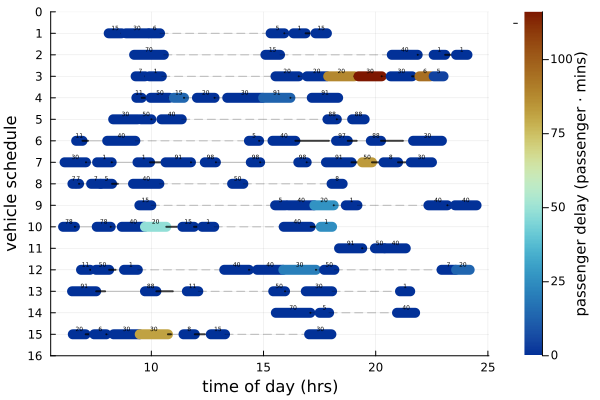

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [71]:
rta_plot_time = plotVSP_time(rta_solution; delays = del_model.L_train .- rta_buffer, ridership = instance.r)

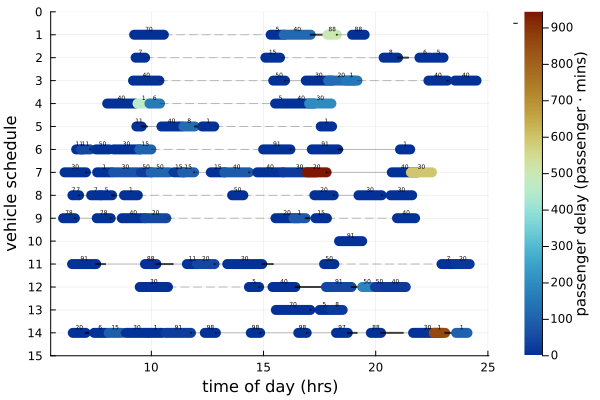

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [72]:
mcf_plot_time = plotVSP_time(mcf_solution; delays = del_model.L_train, ridership = instance.r)
# savefig(mcf_plot_time, ".\\imgs\\VSP-time-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1.png")

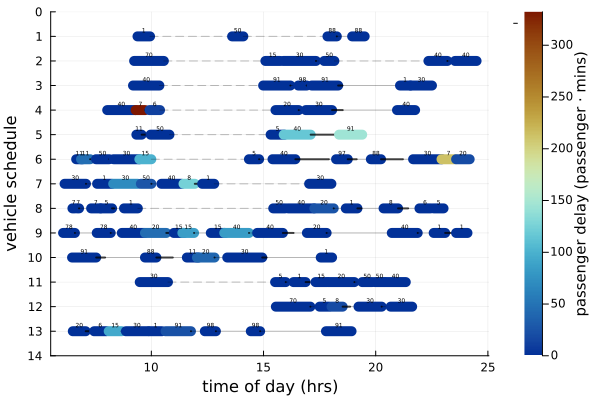

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [73]:
del_plot_time = plotVSP_time(del_solution; delays = del_model.L_train, ridership = instance.r)
# savefig(del_plot_time, ".\\imgs\\VSP-PD-time-$(del_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1.png")

In [7]:
mcf_stats = getSolutionStats(mcf_solution, shapes, del_model.L_train, ridership = instance.r);
rta_stats = getSolutionStats(rta_solution, shapes, del_model.L_train .- rta_buffer, ridership = instance.r);
del_stats = getSolutionStats(del_solution, shapes, del_model.L_train, ridership = instance.r);

In [8]:
@show mcf_stats.cost
@show rta_stats.cost
@show del_stats.cost;

mcf_stats.cost = 35176.99397352424
rta_stats.cost = 33143.190578602385
del_stats.cost = 33176.379950381524


In [10]:
# del_stats.metrics[:, Not("geometry")]
describe(del_stats.metrics[:, Not("geometry")])
# CSV.write(".\\data\\metrics\\VSP-PD-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1-adjacent.csv", del_stats[:, Not("geometry")])

7×7 DataFrame
 Row │ variable                        mean       min        median       max  ⋯
     │ Symbol                          Float64    Real       Float64      Real ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ duration                         2.61167    0.683333   2.825        3.4 ⋯
   2 │ num_trips                        3.0        1          3.0          5
   3 │ utilization                      0.776888   0.644172   0.776583     1.0
   4 │ propagated_passenger_delay       0.103535   0.0        0.0326542    0.5
   5 │ propagated_passenger_delay_err   0.192694   0.0        0.0565588    1.1 ⋯
   6 │ trip_distance                   52.8008    18.649     56.8865      75.4
   7 │ deadhead_distance                0.028717   0.0        0.00326455   0.2
                                                               3 columns omitted

## Leaflet

In [12]:
m = plotVSP_map(del_stats.metrics; schedule = nothing)

Leaflet.Map{Vector{Leaflet.Layer}, Leaflet.Config{Leaflet.Provider}, WebIO.Scope}(Leaflet.Layer[Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05315999999999, 49.23695], [-124.05345, 49.23715], [-124.05318999999999, 49.23795], [-124.05275999999999, 49.23823], [-124.05327, 49.23854], [-124.05381999999999, 49.23871], [-124.05454999999999, 49.2388], [-124.05402, 49.24012], [-124.05373999999999, 49.24083], [-124.05368, 49.24176]  …  [-123.93332, 49.16575], [-123.93288, 49.16589], [-123.93253999999999, 49.16589], [-123.93199, 49.16566], [-123.93154999999999, 49.16528], [-123.93128999999999, 49.16523], [-123.93113, 49.16508], [-123.93105, 49.16481], [-123.93115999999999, 49.16462], [-123.93212999999999, 49.16385]], nothing, nothing), Dict{Symbol, Any}(:color => "#1F77B4", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.9321272705078, 49.163848876953125], [-123.93121937255859, 49.16442108154297]], nothing, nothing), Dict{Symbol, Any}(:color => "gray", :border_width => 2, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93122, 49.16442], [-123.93115999999999, 49.16462], [-123.93105, 49.1648], [-123.93113, 49.16508], [-123.93128999999999, 49.16523], [-123.93234, 49.16584], [-123.93288, 49.16589], [-123.93332, 49.16575], [-123.93363, 49.16573], [-123.93462, 49.16598]  …  [-124.0479, 49.23267], [-124.04793, 49.23301], [-124.04803, 49.23331], [-124.04799, 49.23434], [-124.04799999999999, 49.235], [-124.04878, 49.23501], [-124.04936, 49.23471], [-124.04968, 49.23471], [-124.05228, 49.23635], [-124.05296999999999, 49.23685]], nothing, nothing), Dict{Symbol, Any}(:color => "#1F77B4", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93137999999999, 49.16426], [-123.93133999999999, 49.16445], [-123.93109999999999, 49.16468], [-123.93106999999999, 49.16495], [-123.93128999999999, 49.16523], [-123.93234, 49.16584], [-123.93288, 49.16589], [-123.93332, 49.16575], [-123.93363, 49.16573], [-123.93462, 49.16598]  …  [-124.04149, 49.23446], [-124.04419, 49.23445], [-124.04626999999999, 49.23446], [-124.04799, 49.23446], [-124.04799999999999, 49.235], [-124.04878, 49.23501], [-124.04936, 49.23471], [-124.04968, 49.23471], [-124.05228, 49.23635], [-124.05278999999999, 49.23674]], nothing, nothing), Dict{Symbol, Any}(:color => "#AEC7E8", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93212999999999, 49.16385], [-123.93271, 49.16314], [-123.93298999999999, 49.16321], [-123.93458, 49.16299], [-123.93496999999999, 49.16331], [-123.93571999999999, 49.16358], [-123.93618, 49.16365], [-123.93683999999999, 49.16409], [-123.93804999999999, 49.16463], [-123.93982, 49.16588]  …  [-124.05327, 49.23854], [-124.05275999999999, 49.23823], [-124.05318999999999, 49.23795], [-124.05345999999999, 49.23726], [-124.05332999999999, 49.23701], [-124.05306999999999, 49.23685], [-124.05345999999999, 49.2366], [-124.05275999999999, 49

## Overfitting to Mean

In [9]:
mcf_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
mean_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
stoch_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
numSeeds = 10
n_train = 10
n_test = 100
x = 25:25:100

for n in x
    mean_sim = []
    mean_ut = []
    mean_mean_cost = []
    mean_stoch_cost = []
    mean_mean = []
    mean_stoch = []
    stoch_sim = []
    stoch_ut = []
    stoch_mean_cost = []
    stoch_stoch_cost = []
    stoch_mean = []
    stoch_stoch = []
    mcf_sim = []
    mcf_ut = []
    mcf_mean_cost = []
    mcf_stoch_cost = []
    mcf_mean = []
    mcf_stoch = []
    for seed in 1:numSeeds
        IJulia.clear_output(true)
        println("n: $n")
        println("progress: $seed / $numSeeds")
        subset = subsetGTFS(trips; n = n, randomSeed = seed)
        l = getDelays(subset; randomSeed = seed)
        L = hcat(rand.(l, n_train)...)'
        L = vcat(zeros(Float64, 1, n_train), L)
        L_test = hcat(rand.(l, n_test)...)'
        L_test = vcat(zeros(Float64, 1, n_test), L_test)
        μ_L = mean(L, dims=2)
        μ_L = reshape(μ_L, length(μ_L), 1)
        μ_L_test = mean(L_test, dims=2)
        μ_L_test = reshape(μ_L_test, length(μ_L_test), 1)
        r = getRidership(subset; randomSeed = seed)
        instance = VSPInstance(subset; l = l, r = r)
        mcf_model = MCFModel(instance)
        mcf_solution = solve!(mcf_model)
        mcf_mean_stats = getSolutionStats(mcf_solution, shapes, μ_L_test, ridership = r)
        mcf_stoch_stats = getSolutionStats(mcf_solution, shapes, L_test, ridership = r)
        mean_model = VSPModel(instance; L = μ_L, warmStart = mcf_solution, timeLimit = 120)
        mean_solution = solve!(mean_model)
        mean_mean_stats = getSolutionStats(mean_solution, shapes, μ_L_test, ridership = r)
        mean_stoch_stats = getSolutionStats(mean_solution, shapes, L_test, ridership = r)
        stoch_model = VSPModel(instance; L = L, warmStart = mean_solution, timeLimit = 120)
        stoch_solution = solve!(stoch_model)
        stoch_mean_stats = getSolutionStats(stoch_solution, shapes, μ_L_test, ridership = r)
        stoch_stoch_stats = getSolutionStats(stoch_solution, shapes, L_test, ridership = r)
        
        push!(mcf_sim, compareSchedules(mcf_solution, mcf_solution))
        push!(mcf_ut, mcf_mean_stats.utilization)
        push!(mcf_mean_cost, mcf_mean_stats.cost)
        push!(mcf_stoch_cost, mcf_stoch_stats.cost)
        push!(mcf_mean, mcf_mean_stats.μ)
        push!(mcf_stoch, mcf_stoch_stats.μ)
        push!(mean_sim, compareSchedules(mean_solution, mcf_solution))
        push!(mean_ut, mean_mean_stats.utilization)
        push!(mean_mean_cost, mean_mean_stats.cost)
        push!(mean_stoch_cost, mean_stoch_stats.cost)
        push!(mean_mean, mean_mean_stats.μ)
        push!(mean_stoch, mean_stoch_stats.μ)
        push!(stoch_sim, compareSchedules(stoch_solution, mcf_solution))
        push!(stoch_ut, stoch_mean_stats.utilization)
        push!(stoch_mean_cost, stoch_mean_stats.cost)
        push!(stoch_stoch_cost, stoch_stoch_stats.cost)
        push!(stoch_mean, stoch_mean_stats.μ)
        push!(stoch_stoch, stoch_stoch_stats.μ)
    end

    push!(mcf_dict["similarity"], mean(mcf_sim))
    push!(mcf_dict["similarity_std"], std(mcf_sim))
    push!(mcf_dict["utilization"], mean(mcf_ut))
    push!(mcf_dict["utilization_std"], std(mcf_ut))
    push!(mcf_dict["mean_cost"], mean(mcf_mean_cost))
    push!(mcf_dict["mean_cost_std"], std(mcf_mean_cost))
    push!(mcf_dict["stoch_cost"], mean(mcf_stoch_cost))
    push!(mcf_dict["stoch_cost_std"], std(mcf_stoch_cost))
    push!(mcf_dict["mean_delay"], mean(mcf_mean))
    push!(mcf_dict["mean_std"], std(mcf_mean))
    push!(mcf_dict["stoch_delay"], mean(mcf_stoch))
    push!(mcf_dict["stoch_std"], std(mcf_stoch))
    push!(mean_dict["similarity"], mean(mean_sim))
    push!(mean_dict["similarity_std"], std(mean_sim))
    push!(mean_dict["utilization"], mean(mean_ut))
    push!(mean_dict["utilization_std"], std(mean_ut))
    push!(mean_dict["mean_cost"], mean(mean_mean_cost))
    push!(mean_dict["mean_cost_std"], std(mean_mean_cost))
    push!(mean_dict["stoch_cost"], mean(mean_stoch_cost))
    push!(mean_dict["stoch_cost_std"], std(mean_stoch_cost))
    push!(mean_dict["mean_delay"], mean(mean_mean))
    push!(mean_dict["mean_std"], std(mean_mean))
    push!(mean_dict["stoch_delay"], mean(mean_stoch))
    push!(mean_dict["stoch_std"], std(mean_stoch))
    push!(stoch_dict["similarity"], mean(stoch_sim))
    push!(stoch_dict["similarity_std"], std(stoch_sim))
    push!(stoch_dict["utilization"], mean(stoch_ut))
    push!(stoch_dict["utilization_std"], std(stoch_ut))
    push!(stoch_dict["mean_cost"], mean(stoch_mean_cost))
    push!(stoch_dict["mean_cost_std"], std(stoch_mean_cost))
    push!(stoch_dict["stoch_cost"], mean(stoch_stoch_cost))
    push!(stoch_dict["stoch_cost_std"], std(stoch_stoch_cost))
    push!(stoch_dict["mean_delay"], mean(stoch_mean))
    push!(stoch_dict["mean_std"], std(stoch_mean))
    push!(stoch_dict["stoch_delay"], mean(stoch_stoch))
    push!(stoch_dict["stoch_std"], std(stoch_stoch))
end
println("complete")

n: 100
progress: 10 / 10
complete


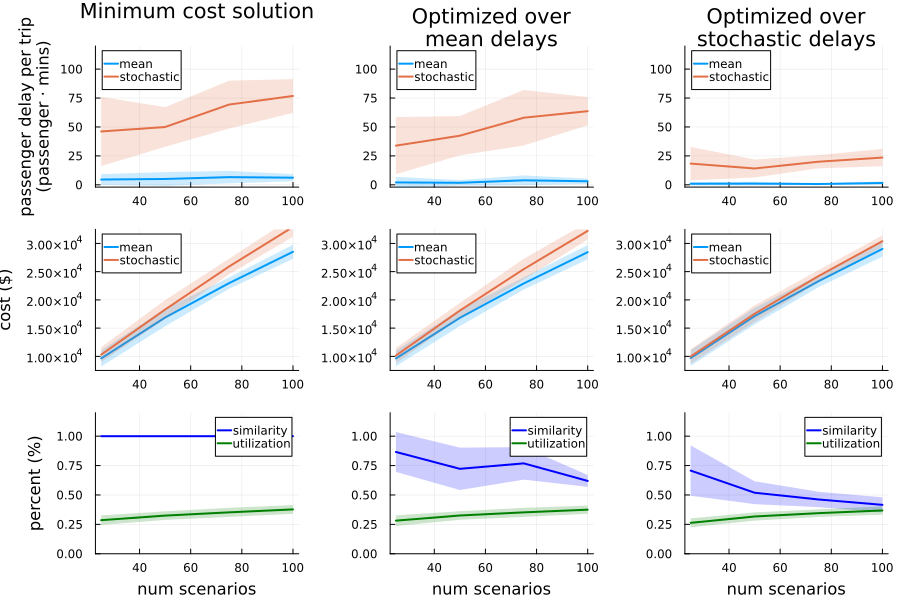

In [14]:
p1 = plot(
    x,
    [mcf_dict["mean_delay"] mcf_dict["stoch_delay"]],
    ribbon=[mcf_dict["mean_std"] mcf_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylabel="passenger delay per trip\n(passenger ⋅ mins)",
    title="Minimum cost solution",
    ylims = (-2, 120),
    legend=:topleft
)
p2 = plot(
    x,
    [mcf_dict["mean_cost"] mcf_dict["stoch_cost"]],
    ribbon=[mcf_dict["mean_cost_std"] mcf_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(7500, 32500),
    ylabel="cost (\$)",
    legend=:topleft
)
p3 = plot(
    x,
    [mcf_dict["similarity"] mcf_dict["utilization"]],
    ribbon=[mcf_dict["similarity_std"] mcf_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="num scenarios",
    ylims=(0, 1.2),
    ylabel="percent (%)",
    legend=:topright
)
p4 = plot(
    x,
    [mean_dict["mean_delay"] mean_dict["stoch_delay"]],
    ribbon=[mean_dict["mean_std"] mean_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nmean delays",
    ylims = (-2, 120),
    legend=:topleft
)
p5 = plot(
    x,
    [mean_dict["mean_cost"] mean_dict["stoch_cost"]],
    ribbon=[mean_dict["mean_cost_std"] mean_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(7500, 32500),
    legend=:topleft
)
p6 = plot(
    x,
    [mean_dict["similarity"] mean_dict["utilization"]],
    ribbon=[mean_dict["similarity_std"] mean_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="num scenarios",
    ylims=(0, 1.2),
    legend=:topright
)
p7 = plot(
    x,
    [stoch_dict["mean_delay"] stoch_dict["stoch_delay"]],
    ribbon=[stoch_dict["mean_std"] stoch_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nstochastic delays",
    ylims = (-2, 120),
    legend=:topleft
)
p8 = plot(
    x,
    [stoch_dict["mean_cost"] stoch_dict["stoch_cost"]],
    ribbon=[stoch_dict["mean_cost_std"] stoch_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(7500, 32500),
    legend=:topleft
)
p9 = plot(
    x,
    [stoch_dict["similarity"] stoch_dict["utilization"]],
    ribbon=[stoch_dict["similarity_std"] stoch_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="num scenarios",
    ylims=(0, 1.2),
    legend=:topright
)
overfit_plot = plot(p1, p4, p7, p2, p5, p8, p3, p6, p9,  layout=(3, 3), link=:xy, size=(900, 600))
# savefig(overfit_plot, ".\\imgs\\VSP-PD-100-10_10-overfit_unseen.png")

## Spectrum of delay

In [15]:
mcf_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
mean_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
stoch_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
numSeeds = 10
n_train = 10
n_test = 100

for std_multi in 0.1:0.1:1.0
    mean_sim = []
    mean_ut = []
    mean_mean_cost = []
    mean_stoch_cost = []
    mean_mean = []
    mean_stoch = []
    stoch_sim = []
    stoch_ut = []
    stoch_mean_cost = []
    stoch_stoch_cost = []
    stoch_mean = []
    stoch_stoch = []
    mcf_sim = []
    mcf_ut = []
    mcf_mean_cost = []
    mcf_stoch_cost = []
    mcf_mean = []
    mcf_stoch = []
    for seed in 1:numSeeds
        IJulia.clear_output(true)
        println("\rstd_multi: $std_multi")
        println("\rprogress: $seed / $numSeeds")
        subset = subsetGTFS(trips; n = 100, randomSeed = seed)
        l = getDelays(subset; randomSeed = seed, stdMulti = std_multi)
        L = hcat(rand.(l, n_train)...)'
        L = vcat(zeros(Float64, 1, n_train), L)
        L_test = hcat(rand.(l, n_test)...)'
        L_test = vcat(zeros(Float64, 1, n_test), L_test)
        μ_L = mean(L, dims=2)
        μ_L = reshape(μ_L, length(μ_L), 1)
        μ_L_test = mean(L_test, dims=2)
        μ_L_test = reshape(μ_L_test, length(μ_L_test), 1)
        r = getRidership(subset; randomSeed = seed)
        instance = VSPInstance(subset; l = l, r = r)
        mcf_model = MCFModel(instance)
        mcf_solution = solve!(mcf_model)
        mcf_mean_stats = getSolutionStats(mcf_solution, shapes, μ_L_test, ridership = r)
        mcf_stoch_stats = getSolutionStats(mcf_solution, shapes, L_test, ridership = r)
        mean_model = VSPModel(instance; L = μ_L, warmStart = mcf_solution, timeLimit = 120)
        mean_solution = solve!(mean_model)
        mean_mean_stats = getSolutionStats(mean_solution, shapes, μ_L_test, ridership = r)
        mean_stoch_stats = getSolutionStats(mean_solution, shapes, L_test, ridership = r)
        stoch_model = VSPModel(instance; L = L, warmStart = mean_solution, timeLimit = 120)
        stoch_solution = solve!(stoch_model)
        stoch_mean_stats = getSolutionStats(stoch_solution, shapes, μ_L_test, ridership = r)
        stoch_stoch_stats = getSolutionStats(stoch_solution, shapes, L_test, ridership = r)
        
        push!(mcf_sim, compareSchedules(mcf_solution, mcf_solution))
        push!(mcf_ut, mcf_mean_stats.utilization)
        push!(mcf_mean_cost, mcf_mean_stats.cost)
        push!(mcf_stoch_cost, mcf_stoch_stats.cost)
        push!(mcf_mean, mcf_mean_stats.μ)
        push!(mcf_stoch, mcf_stoch_stats.μ)
        push!(mean_sim, compareSchedules(mean_solution, mcf_solution))
        push!(mean_ut, mean_mean_stats.utilization)
        push!(mean_mean_cost, mean_mean_stats.cost)
        push!(mean_stoch_cost, mean_stoch_stats.cost)
        push!(mean_mean, mean_mean_stats.μ)
        push!(mean_stoch, mean_stoch_stats.μ)
        push!(stoch_sim, compareSchedules(stoch_solution, mcf_solution))
        push!(stoch_ut, stoch_mean_stats.utilization)
        push!(stoch_mean_cost, stoch_mean_stats.cost)
        push!(stoch_stoch_cost, stoch_stoch_stats.cost)
        push!(stoch_mean, stoch_mean_stats.μ)
        push!(stoch_stoch, stoch_stoch_stats.μ)
    end

    push!(mcf_dict["similarity"], mean(mcf_sim))
    push!(mcf_dict["similarity_std"], std(mcf_sim))
    push!(mcf_dict["utilization"], mean(mcf_ut))
    push!(mcf_dict["utilization_std"], std(mcf_ut))
    push!(mcf_dict["mean_cost"], mean(mcf_mean_cost))
    push!(mcf_dict["mean_cost_std"], std(mcf_mean_cost))
    push!(mcf_dict["stoch_cost"], mean(mcf_stoch_cost))
    push!(mcf_dict["stoch_cost_std"], std(mcf_stoch_cost))
    push!(mcf_dict["mean_delay"], mean(mcf_mean))
    push!(mcf_dict["mean_std"], std(mcf_mean))
    push!(mcf_dict["stoch_delay"], mean(mcf_stoch))
    push!(mcf_dict["stoch_std"], std(mcf_stoch))
    push!(mean_dict["similarity"], mean(mean_sim))
    push!(mean_dict["similarity_std"], std(mean_sim))
    push!(mean_dict["utilization"], mean(mean_ut))
    push!(mean_dict["utilization_std"], std(mean_ut))
    push!(mean_dict["mean_cost"], mean(mean_mean_cost))
    push!(mean_dict["mean_cost_std"], std(mean_mean_cost))
    push!(mean_dict["stoch_cost"], mean(mean_stoch_cost))
    push!(mean_dict["stoch_cost_std"], std(mean_stoch_cost))
    push!(mean_dict["mean_delay"], mean(mean_mean))
    push!(mean_dict["mean_std"], std(mean_mean))
    push!(mean_dict["stoch_delay"], mean(mean_stoch))
    push!(mean_dict["stoch_std"], std(mean_stoch))
    push!(stoch_dict["similarity"], mean(stoch_sim))
    push!(stoch_dict["similarity_std"], std(stoch_sim))
    push!(stoch_dict["utilization"], mean(stoch_ut))
    push!(stoch_dict["utilization_std"], std(stoch_ut))
    push!(stoch_dict["mean_cost"], mean(stoch_mean_cost))
    push!(stoch_dict["mean_cost_std"], std(stoch_mean_cost))
    push!(stoch_dict["stoch_cost"], mean(stoch_stoch_cost))
    push!(stoch_dict["stoch_cost_std"], std(stoch_stoch_cost))
    push!(stoch_dict["mean_delay"], mean(stoch_mean))
    push!(stoch_dict["mean_std"], std(stoch_mean))
    push!(stoch_dict["stoch_delay"], mean(stoch_stoch))
    push!(stoch_dict["stoch_std"], std(stoch_stoch))
end
println("complete")

std_multi: 1.0
progress: 10 / 10
complete


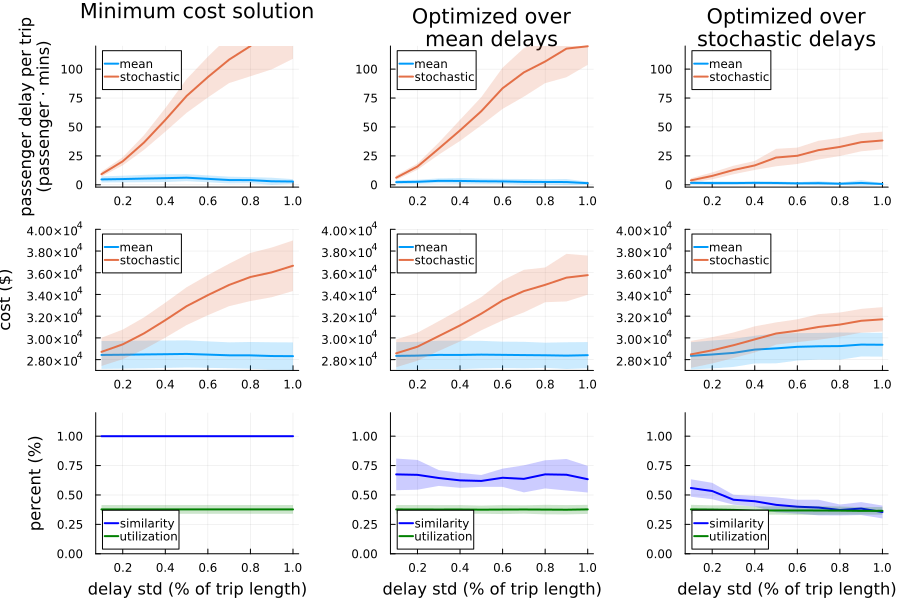

In [20]:
p1 = plot(
    0.1:0.1:1.0,
    [mcf_dict["mean_delay"] mcf_dict["stoch_delay"]],
    ribbon=[mcf_dict["mean_std"] mcf_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylabel="passenger delay per trip\n(passenger ⋅ mins)",
    title="Minimum cost solution",
    ylims = (-2, 120),
    legend=:topleft
)
p2 = plot(
    0.1:0.1:1.0,
    [mcf_dict["mean_cost"] mcf_dict["stoch_cost"]],
    ribbon=[mcf_dict["mean_cost_std"] mcf_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(27000, 40000),
    ylabel="cost (\$)",
    legend=:topleft
)
p3 = plot(
    0.1:0.1:1.0,
    [mcf_dict["similarity"] mcf_dict["utilization"]],
    ribbon=[mcf_dict["similarity_std"] mcf_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay std (% of trip length)",
    ylims=(0, 1.2),
    ylabel="percent (%)",
    legend=:bottomleft
)
p4 = plot(
    0.1:0.1:1.0,
    [mean_dict["mean_delay"] mean_dict["stoch_delay"]],
    ribbon=[mean_dict["mean_std"] mean_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nmean delays",
    ylims = (-2, 120),
    legend=:topleft
)
p5 = plot(
    0.1:0.1:1.0,
    [mean_dict["mean_cost"] mean_dict["stoch_cost"]],
    ribbon=[mean_dict["mean_cost_std"] mean_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(27000, 40000),
    legend=:topleft
)
p6 = plot(
    0.1:0.1:1.0,
    [mean_dict["similarity"] mean_dict["utilization"]],
    ribbon=[mean_dict["similarity_std"] mean_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay std (% of trip length)",
    ylims=(0, 1.2),
    legend=:bottomleft
)
p7 = plot(
    0.1:0.1:1.0,
    [stoch_dict["mean_delay"] stoch_dict["stoch_delay"]],
    ribbon=[stoch_dict["mean_std"] stoch_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nstochastic delays",
    ylims = (-2, 120),
    legend=:topleft
)
p8 = plot(
    0.1:0.1:1.0,
    [stoch_dict["mean_cost"] stoch_dict["stoch_cost"]],
    ribbon=[stoch_dict["mean_cost_std"] stoch_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(27000, 40000),
    legend=:topleft
)
p9 = plot(
    0.1:0.1:1.0,
    [stoch_dict["similarity"] stoch_dict["utilization"]],
    ribbon=[stoch_dict["similarity_std"] stoch_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay std (% of trip length)",
    ylims=(0, 1.2),
    legend=:bottomleft
)
delay_spectrum_plot = plot(p1, p4, p7, p2, p5, p8, p3, p6, p9,  layout=(3, 3), link=:xy, size=(900, 600))
# savefig(delay_spectrum_plot, ".\\imgs\\VSP-PD-100-10_10-delay_spectrum_unseen.png")

## How many scenarios

In [35]:
mcf_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
mean_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
stoch_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
numSeeds = 10
n_test = 100
x = 1:10

for n in x
    mean_sim = []
    mean_ut = []
    mean_mean_cost = []
    mean_stoch_cost = []
    mean_mean = []
    mean_stoch = []
    stoch_sim = []
    stoch_ut = []
    stoch_mean_cost = []
    stoch_stoch_cost = []
    stoch_mean = []
    stoch_stoch = []
    mcf_sim = []
    mcf_ut = []
    mcf_mean_cost = []
    mcf_stoch_cost = []
    mcf_mean = []
    mcf_stoch = []
    for seed in 1:numSeeds
        IJulia.clear_output(true)
        println("n: $n")
        println("progress: $seed / $numSeeds")
        subset = subsetGTFS(trips; n = 100, randomSeed = seed)
        l = getDelays(subset; randomSeed = seed)
        L = hcat(rand.(l, n)...)'
        L = vcat(zeros(Float64, 1, n), L)
        L_test = hcat(rand.(l, n_test)...)'
        L_test = vcat(zeros(Float64, 1, n_test), L_test)
        μ_L = mean(L, dims=2)
        μ_L = reshape(μ_L, length(μ_L), 1)
        μ_L_test = mean(L_test, dims=2)
        μ_L_test = reshape(μ_L_test, length(μ_L_test), 1)
        r = getRidership(subset; randomSeed = seed)
        instance = VSPInstance(subset; l = l, r = r)
        mcf_model = MCFModel(instance)
        mcf_solution = solve!(mcf_model)
        mcf_mean_stats = getSolutionStats(mcf_solution, shapes, μ_L_test, ridership = r)
        mcf_stoch_stats = getSolutionStats(mcf_solution, shapes, L_test, ridership = r)
        mean_model = VSPModel(instance; L = μ_L, warmStart = mcf_solution, timeLimit = 120)
        mean_solution = solve!(mean_model)
        mean_mean_stats = getSolutionStats(mean_solution, shapes, μ_L_test, ridership = r)
        mean_stoch_stats = getSolutionStats(mean_solution, shapes, L_test, ridership = r)
        stoch_model = VSPModel(instance; L = L, warmStart = mean_solution, timeLimit = 120)
        stoch_solution = solve!(stoch_model)
        stoch_mean_stats = getSolutionStats(stoch_solution, shapes, μ_L_test, ridership = r)
        stoch_stoch_stats = getSolutionStats(stoch_solution, shapes, L_test, ridership = r)
        
        push!(mcf_sim, compareSchedules(mcf_solution, mcf_solution))
        push!(mcf_ut, mcf_mean_stats.utilization)
        push!(mcf_mean_cost, mcf_mean_stats.cost)
        push!(mcf_stoch_cost, mcf_stoch_stats.cost)
        push!(mcf_mean, mcf_mean_stats.μ)
        push!(mcf_stoch, mcf_stoch_stats.μ)
        push!(mean_sim, compareSchedules(mean_solution, mcf_solution))
        push!(mean_ut, mean_mean_stats.utilization)
        push!(mean_mean_cost, mean_mean_stats.cost)
        push!(mean_stoch_cost, mean_stoch_stats.cost)
        push!(mean_mean, mean_mean_stats.μ)
        push!(mean_stoch, mean_stoch_stats.μ)
        push!(stoch_sim, compareSchedules(stoch_solution, mcf_solution))
        push!(stoch_ut, stoch_mean_stats.utilization)
        push!(stoch_mean_cost, stoch_mean_stats.cost)
        push!(stoch_stoch_cost, stoch_stoch_stats.cost)
        push!(stoch_mean, stoch_mean_stats.μ)
        push!(stoch_stoch, stoch_stoch_stats.μ)
    end

    push!(mcf_dict["similarity"], mean(mcf_sim))
    push!(mcf_dict["similarity_std"], std(mcf_sim))
    push!(mcf_dict["utilization"], mean(mcf_ut))
    push!(mcf_dict["utilization_std"], std(mcf_ut))
    push!(mcf_dict["mean_cost"], mean(mcf_mean_cost))
    push!(mcf_dict["mean_cost_std"], std(mcf_mean_cost))
    push!(mcf_dict["stoch_cost"], mean(mcf_stoch_cost))
    push!(mcf_dict["stoch_cost_std"], std(mcf_stoch_cost))
    push!(mcf_dict["mean_delay"], mean(mcf_mean))
    push!(mcf_dict["mean_std"], std(mcf_mean))
    push!(mcf_dict["stoch_delay"], mean(mcf_stoch))
    push!(mcf_dict["stoch_std"], std(mcf_stoch))
    push!(mean_dict["similarity"], mean(mean_sim))
    push!(mean_dict["similarity_std"], std(mean_sim))
    push!(mean_dict["utilization"], mean(mean_ut))
    push!(mean_dict["utilization_std"], std(mean_ut))
    push!(mean_dict["mean_cost"], mean(mean_mean_cost))
    push!(mean_dict["mean_cost_std"], std(mean_mean_cost))
    push!(mean_dict["stoch_cost"], mean(mean_stoch_cost))
    push!(mean_dict["stoch_cost_std"], std(mean_stoch_cost))
    push!(mean_dict["mean_delay"], mean(mean_mean))
    push!(mean_dict["mean_std"], std(mean_mean))
    push!(mean_dict["stoch_delay"], mean(mean_stoch))
    push!(mean_dict["stoch_std"], std(mean_stoch))
    push!(stoch_dict["similarity"], mean(stoch_sim))
    push!(stoch_dict["similarity_std"], std(stoch_sim))
    push!(stoch_dict["utilization"], mean(stoch_ut))
    push!(stoch_dict["utilization_std"], std(stoch_ut))
    push!(stoch_dict["mean_cost"], mean(stoch_mean_cost))
    push!(stoch_dict["mean_cost_std"], std(stoch_mean_cost))
    push!(stoch_dict["stoch_cost"], mean(stoch_stoch_cost))
    push!(stoch_dict["stoch_cost_std"], std(stoch_stoch_cost))
    push!(stoch_dict["mean_delay"], mean(stoch_mean))
    push!(stoch_dict["mean_std"], std(stoch_mean))
    push!(stoch_dict["stoch_delay"], mean(stoch_stoch))
    push!(stoch_dict["stoch_std"], std(stoch_stoch))
end
println("complete")

n: 10
progress: 10 / 10
complete


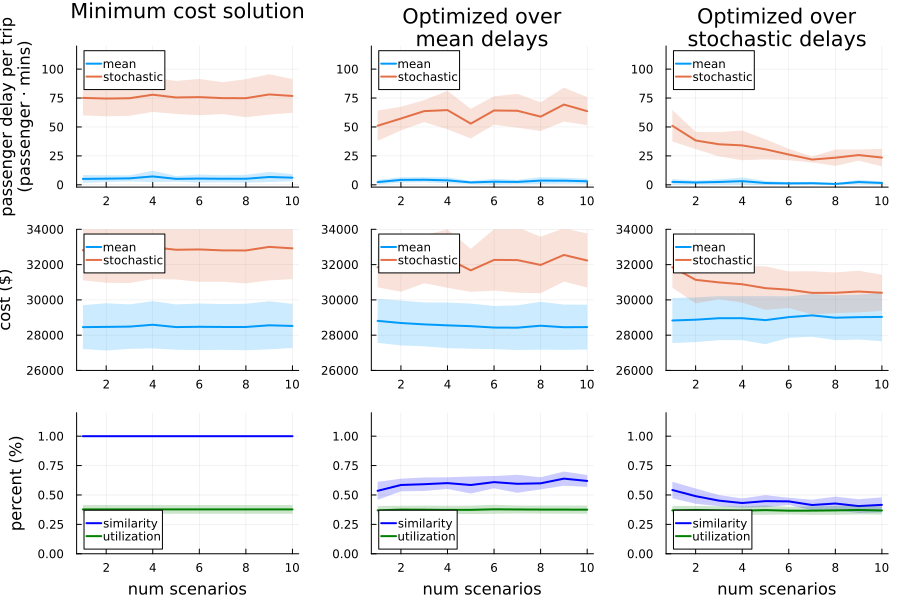

In [39]:
p1 = plot(
    x,
    [mcf_dict["mean_delay"] mcf_dict["stoch_delay"]],
    ribbon=[mcf_dict["mean_std"] mcf_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylabel="passenger delay per trip\n(passenger ⋅ mins)",
    title="Minimum cost solution",
    ylims = (-2, 120),
    legend=:topleft
)
p2 = plot(
    x,
    [mcf_dict["mean_cost"] mcf_dict["stoch_cost"]],
    ribbon=[mcf_dict["mean_cost_std"] mcf_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(26000, 34000),
    ylabel="cost (\$)",
    legend=:topleft
)
p3 = plot(
    x,
    [mcf_dict["similarity"] mcf_dict["utilization"]],
    ribbon=[mcf_dict["similarity_std"] mcf_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="num scenarios",
    ylims=(0, 1.2),
    ylabel="percent (%)",
    legend=:bottomleft
)
p4 = plot(
    x,
    [mean_dict["mean_delay"] mean_dict["stoch_delay"]],
    ribbon=[mean_dict["mean_std"] mean_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nmean delays",
    ylims = (-2, 120),
    legend=:topleft
)
p5 = plot(
    x,
    [mean_dict["mean_cost"] mean_dict["stoch_cost"]],
    ribbon=[mean_dict["mean_cost_std"] mean_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(26000, 34000),
    legend=:topleft
)
p6 = plot(
    x,
    [mean_dict["similarity"] mean_dict["utilization"]],
    ribbon=[mean_dict["similarity_std"] mean_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="num scenarios",
    ylims=(0, 1.2),
    legend=:bottomleft
)
p7 = plot(
    x,
    [stoch_dict["mean_delay"] stoch_dict["stoch_delay"]],
    ribbon=[stoch_dict["mean_std"] stoch_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nstochastic delays",
    ylims = (-2, 120),
    legend=:topleft
)
p8 = plot(
    x,
    [stoch_dict["mean_cost"] stoch_dict["stoch_cost"]],
    ribbon=[stoch_dict["mean_cost_std"] stoch_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(26000, 34000),
    legend=:topleft
)
p9 = plot(
    x,
    [stoch_dict["similarity"] stoch_dict["utilization"]],
    ribbon=[stoch_dict["similarity_std"] stoch_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="num scenarios",
    ylims=(0, 1.2),
    legend=:bottomleft
)
scenarios_plot = plot(p1, p4, p7, p2, p5, p8, p3, p6, p9,  layout=(3, 3), link=:xy, size=(900, 600))
# savefig(scenarios_plot, ".\\imgs\\VSP-PD-100-10_1-10-scenarios_unseen.png")

## RTA Comparison

In [40]:
mcf_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
rta_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
stoch_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "mean_cost" => [],
    "mean_cost_std" => [],
    "stoch_cost" => [],
    "stoch_cost_std" => [],
    "mean_delay" => [],
    "mean_std" => [],
    "stoch_delay" => [],
    "stoch_std" => [],
)
numSeeds = 10
n_train = 10
n_test = 100
multis = 0.0:0.05:0.5

for multi in multis
    rta_sim = []
    rta_ut = []
    rta_mean_cost = []
    rta_stoch_cost = []
    rta_mean = []
    rta_stoch = []
    stoch_sim = []
    stoch_ut = []
    stoch_mean_cost = []
    stoch_stoch_cost = []
    stoch_mean = []
    stoch_stoch = []
    mcf_sim = []
    mcf_ut = []
    mcf_mean_cost = []
    mcf_stoch_cost = []
    mcf_mean = []
    mcf_stoch = []
    for seed in 1:numSeeds
        IJulia.clear_output(true)
        println("\rstd_multi: $multi")
        println("\rprogress: $seed / $numSeeds")
        subset = subsetGTFS(trips; n = 100, randomSeed = seed)
        l = getDelays(subset; randomSeed = seed, meanMulti = multi)
        L = hcat(rand.(l, n_train)...)'
        L = vcat(zeros(Float64, 1, n_train), L)
        L_test = hcat(rand.(l, n_test)...)'
        L_test = vcat(zeros(Float64, 1, n_test), L_test)
        μ_L = mean(L, dims=2)
        μ_L = reshape(μ_L, length(μ_L), 1)
        μ_L_test = mean(L_test, dims=2)
        μ_L_test = reshape(μ_L_test, length(μ_L_test), 1)
        r = getRidership(subset; randomSeed = seed)
        instance = VSPInstance(subset; l = l, r = r)
        mcf_model = MCFModel(instance)
        mcf_solution = solve!(mcf_model)
        mcf_mean_stats = getSolutionStats(mcf_solution, shapes, μ_L_test, ridership = r)
        mcf_stoch_stats = getSolutionStats(mcf_solution, shapes, L_test, ridership = r)
        stoch_model = VSPModel(instance; L = L, warmStart = mcf_solution, timeLimit = 120)
        stoch_solution = solve!(stoch_model)
        stoch_mean_stats = getSolutionStats(stoch_solution, shapes, μ_L_test, ridership = r)
        stoch_stoch_stats = getSolutionStats(stoch_solution, shapes, L_test, ridership = r)
        rta_solution, rta_buffer = runTimeAnalysis(mcf_solution, L)
        rta_mean_stats = getSolutionStats(rta_solution, shapes, μ_L_test .- rta_buffer, ridership = r)
        rta_stoch_stats = getSolutionStats(rta_solution, shapes, L_test .- rta_buffer, ridership = r)
        
        push!(mcf_sim, compareSchedules(mcf_solution, mcf_solution))
        push!(mcf_ut, mcf_mean_stats.utilization)
        push!(mcf_mean_cost, mcf_mean_stats.cost)
        push!(mcf_stoch_cost, mcf_stoch_stats.cost)
        push!(mcf_mean, mcf_mean_stats.μ)
        push!(mcf_stoch, mcf_stoch_stats.μ)
        push!(rta_sim, compareSchedules(rta_solution, mcf_solution))
        push!(rta_ut, rta_mean_stats.utilization)
        push!(rta_mean_cost, rta_mean_stats.cost)
        push!(rta_stoch_cost, rta_stoch_stats.cost)
        push!(rta_mean, rta_mean_stats.μ)
        push!(rta_stoch, rta_stoch_stats.μ)
        push!(stoch_sim, compareSchedules(stoch_solution, mcf_solution))
        push!(stoch_ut, stoch_mean_stats.utilization)
        push!(stoch_mean_cost, stoch_mean_stats.cost)
        push!(stoch_stoch_cost, stoch_stoch_stats.cost)
        push!(stoch_mean, stoch_mean_stats.μ)
        push!(stoch_stoch, stoch_stoch_stats.μ)
    end

    push!(mcf_dict["similarity"], mean(mcf_sim))
    push!(mcf_dict["similarity_std"], std(mcf_sim))
    push!(mcf_dict["utilization"], mean(mcf_ut))
    push!(mcf_dict["utilization_std"], std(mcf_ut))
    push!(mcf_dict["mean_cost"], mean(mcf_mean_cost))
    push!(mcf_dict["mean_cost_std"], std(mcf_mean_cost))
    push!(mcf_dict["stoch_cost"], mean(mcf_stoch_cost))
    push!(mcf_dict["stoch_cost_std"], std(mcf_stoch_cost))
    push!(mcf_dict["mean_delay"], mean(mcf_mean))
    push!(mcf_dict["mean_std"], std(mcf_mean))
    push!(mcf_dict["stoch_delay"], mean(mcf_stoch))
    push!(mcf_dict["stoch_std"], std(mcf_stoch))
    push!(rta_dict["similarity"], mean(rta_sim))
    push!(rta_dict["similarity_std"], std(rta_sim))
    push!(rta_dict["utilization"], mean(rta_ut))
    push!(rta_dict["utilization_std"], std(rta_ut))
    push!(rta_dict["mean_cost"], mean(rta_mean_cost))
    push!(rta_dict["mean_cost_std"], std(rta_mean_cost))
    push!(rta_dict["stoch_cost"], mean(rta_stoch_cost))
    push!(rta_dict["stoch_cost_std"], std(rta_stoch_cost))
    push!(rta_dict["mean_delay"], mean(rta_mean))
    push!(rta_dict["mean_std"], std(rta_mean))
    push!(rta_dict["stoch_delay"], mean(rta_stoch))
    push!(rta_dict["stoch_std"], std(rta_stoch))
    push!(stoch_dict["similarity"], mean(stoch_sim))
    push!(stoch_dict["similarity_std"], std(stoch_sim))
    push!(stoch_dict["utilization"], mean(stoch_ut))
    push!(stoch_dict["utilization_std"], std(stoch_ut))
    push!(stoch_dict["mean_cost"], mean(stoch_mean_cost))
    push!(stoch_dict["mean_cost_std"], std(stoch_mean_cost))
    push!(stoch_dict["stoch_cost"], mean(stoch_stoch_cost))
    push!(stoch_dict["stoch_cost_std"], std(stoch_stoch_cost))
    push!(stoch_dict["mean_delay"], mean(stoch_mean))
    push!(stoch_dict["mean_std"], std(stoch_mean))
    push!(stoch_dict["stoch_delay"], mean(stoch_stoch))
    push!(stoch_dict["stoch_std"], std(stoch_stoch))
end
println("complete")

std_multi: 0.5
progress: 10 / 10
complete


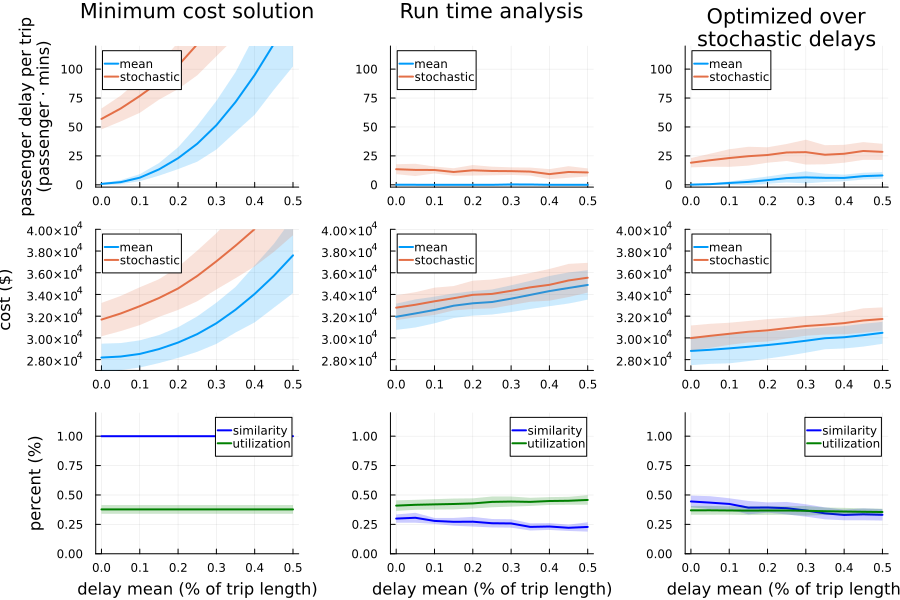

In [44]:
p1 = plot(
    multis,
    [mcf_dict["mean_delay"] mcf_dict["stoch_delay"]],
    ribbon=[mcf_dict["mean_std"] mcf_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylabel="passenger delay per trip\n(passenger ⋅ mins)",
    title="Minimum cost solution",
    ylims = (-2, 120),
    legend=:topleft
)
p2 = plot(
    multis,
    [mcf_dict["mean_cost"] mcf_dict["stoch_cost"]],
    ribbon=[mcf_dict["mean_cost_std"] mcf_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(27000, 40000),
    ylabel="cost (\$)",
    legend=:topleft
)
p3 = plot(
    multis,
    [mcf_dict["similarity"] mcf_dict["utilization"]],
    ribbon=[mcf_dict["similarity_std"] mcf_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay mean (% of trip length)",
    ylims=(0, 1.2),
    ylabel="percent (%)",
    legend=:topright
)
p4 = plot(
    multis,
    [rta_dict["mean_delay"] rta_dict["stoch_delay"]],
    ribbon=[rta_dict["mean_std"] rta_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Run time analysis",
    ylims = (-2, 120),
    legend=:topleft
)
p5 = plot(
    multis,
    [rta_dict["mean_cost"] rta_dict["stoch_cost"]],
    ribbon=[rta_dict["mean_cost_std"] rta_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(27000, 40000),
    legend=:topleft
)
p6 = plot(
    multis,
    [rta_dict["similarity"] rta_dict["utilization"]],
    ribbon=[rta_dict["similarity_std"] rta_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay mean (% of trip length)",
    ylims=(0, 1.2),
    legend=:topright
)
p7 = plot(
    multis,
    [stoch_dict["mean_delay"] stoch_dict["stoch_delay"]],
    ribbon=[stoch_dict["mean_std"] stoch_dict["stoch_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    title="Optimized over\nstochastic delays",
    ylims = (-2, 120),
    legend=:topleft
)
p8 = plot(
    multis,
    [stoch_dict["mean_cost"] stoch_dict["stoch_cost"]],
    ribbon=[stoch_dict["mean_cost_std"] stoch_dict["stoch_cost_std"]],
    label=["mean" "stochastic"],
    lw=2,
    fillalpha=0.2,
    ylims=(27000, 40000),
    legend=:topleft
)
p9 = plot(
    multis,
    [stoch_dict["similarity"] stoch_dict["utilization"]],
    ribbon=[stoch_dict["similarity_std"] stoch_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay mean (% of trip length)",
    ylims=(0, 1.2),
    legend=:topright
)
rta_comparison_plot = plot(p1, p4, p7, p2, p5, p8, p3, p6, p9,  layout=(3, 3), link=:xy, size=(900, 600))
# savefig(rta_comparison_plot, ".\\imgs\\VSP-PD-100-10_10-rta_mean_comparison.png")

## Bender's decomposition

In [9]:
# fs = FirstStageProblem(instance; timeLimit = 10)
# add_benders_callback!(fs)
# bd_solution = solve!(fs);
# @show mean(lp_callback_runtimes)
# @show mean(get_p_callback_runtimes);
# MOI.get(fs.model, MOI.RelativeGap())
# plotVSP(bd_solution)

## 10 sec opt gap

In [11]:
# instance_sizes = 100:100:500
# opt_gap_IP = []
# opt_gap_BD = []

# for size in instance_sizes
#     sum_IP = 0
#     sum_BD = 0
#     for i in 1:5
#         subset = subsetGTFS(trips, size, randomSeed = i)
#         instance = VSPInstance(subset)
#         model_IP = VSPModel(instance, isInt = true, multiObj = false, timeLimit = 10)
#         model_BD = FirstStageProblem(instance, timeLimit = 10)
#         add_benders_callback!(model_BD)
#         sol_IP = solve!(model_IP);
#         sol_BD = solve!(model_BD);
#         sum_IP += MOI.get(model_IP.model, MOI.RelativeGap())
#         sum_BD += MOI.get(model_BD.model, MOI.RelativeGap())
#     end
#     push!(opt_gap_IP, sum_IP / 5)
#     push!(opt_gap_BD, sum_BD / 5)
# end
@show [opt_gap_IP opt_gap_BD]

[opt_gap_IP opt_gap_BD] = [6.031947682607448e-6 0.1629275916113045; 0.027256919099971622 0.47132052625010956; 0.526180825699331 0.768839649480148; 0.7067324202226736 0.8463141117589137]


4×2 Matrix{Float64}:
 6.03195e-6  0.162928
 0.0272569   0.471321
 0.526181    0.76884
 0.706732    0.846314

## Lagrange relaxation

In [51]:
LR = LagrangeRelaxation(instance)

for i ∈ 1:100
    status = update!(LR)
    if status
        println(i)
        break
    end
end

Solution found within 1% optimality gap.
3


In [60]:
# plot([LR.UB LR.LB])
# hline!([objectiveValue(vsp_solution.x, vsp_solution.s, instance.C, instance.M)])
# plot(LR.opt_gap, ylims = [0, 1])
# LR.λ
# println(
#     "vsp: ",
#     sum(LR.x[LR.best_idx[1]] .+ vsp_solution.x .> 1) / sum(vsp_solution.x),
#     "; mcf: ",
#     sum(LR.x[LR.best_idx[1]] .+ mcf_solution.x .> 1) / sum(mcf_solution.x)
# )
# (minimum(LR.UB) .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# (LR.UB[1] .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# LR.s_adj
# plotVSP(instance, LR.x[LR.best_idx[1]], LR.s_adj[LR.best_idx[1]])

## solve times

In [8]:
# solve times
# instance_sizes = 20:20:200
# sol_times_LP = []
# sol_times_IP = []
# sol_times_BD = []

# for size in instance_sizes
#     sum_LP = 0
#     sum_IP = 0
    # sum_BD = 0
    # for i in 1:5
    #     subset = subsetGTFS(trips, size, randomSeed = i)
    #     instance = VSPInstance(subset)
    #     model_LP = VSPModel(instance, isInt = false, multiObj = false)
    #     model_IP = VSPModel(instance, isInt = true, multiObj = false)
        # model_BD = FirstStageProblem(instance)
        # add_benders_callback!(model_BD)
        # sol_LP = solve!(model_LP);
        # sol_IP = solve!(model_IP);
        # sol_BD = solve!(model_BD);
        # sum_LP += sol_LP.solve_time
        # sum_IP += sol_IP.solve_time
        # sum_BD += sol_BD.solve_time
    # end
    # push!(sol_times_LP, sum_LP / 5)
    # push!(sol_times_IP, sum_IP / 5)
    # push!(sol_times_BD, sum_BD / 5)
# end
# plot(
#     instance_sizes,
#     [sol_times_LP sol_times_IP];
#     xlabel = "number of trips",
#     ylabel = "solve time",
#     title = "LP, and IP solution times",
#     label = ["LP" "IP"]
# )
# png(".\\imgs\\VSP-PD-solve_times-BD")

## Pareto frontier

In [94]:
# Pareto frontier
# mod = del_model.model
# used_vehicles = [round(sum(value.(del_model.x[1, :]; result = i)); digits = 3) for i in 1:result_count(mod)]
# ideal_point = objective_bound(mod)
# pareto_plot = hline([ideal_point[2]]; color = :red, lw = 2, label = "", ylims = [1000, 2000], xlims = [-0.2, 7])
# vline!([ideal_point[1]]; color = :red, lw = 2, label = "objective bounds")
# Plots.scatter!(
#     [objective_value(mod; result = i)[1] for i in 1:result_count(mod)],
#     [objective_value(mod; result = i)[2] for i in 1:result_count(mod)];
#     xlabel = "delay",
#     ylabel = "cost",
#     title = "# trips: $(instance.n-1)",
#     label = "fleet used",
# )
# for i in 1:result_count(mod)
#     y = objective_value(mod; result = i)
#     Plots.annotate!(y[1], y[2] + 10, (used_vehicles[i], 10))
# end
# png(".\\imgs\\VSP-PD-$(instance.n-1)-pareto")
# pareto_plot